In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-06-22 14:17:25.179658: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 14:17:25.179799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 14:17:25.379331: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/imdb-movie-ratings-sentiment-analysis/movie.csv
/kaggle/input/glove-6b-100d-txt/glove.6B.100d.txt


In [2]:
df = pd.read_csv('/kaggle/input/imdb-movie-ratings-sentiment-analysis/movie.csv')
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [3]:
df.shape

(40000, 2)

In [4]:
df.duplicated().sum()

277

In [5]:
# dropping the duplicate values
df.drop_duplicates(inplace=True)

In [6]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [7]:
df['label'].value_counts()

label
1    19908
0    19815
Name: count, dtype: int64

## Most frequent words in Positive reviews

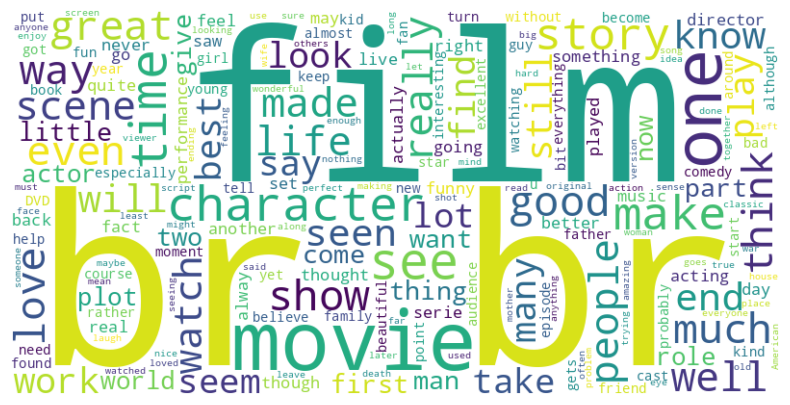

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_review = df[df['label']==1]['text']
positive_text = ' '.join(positive_review)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

## Most frequent words in Negative reviews

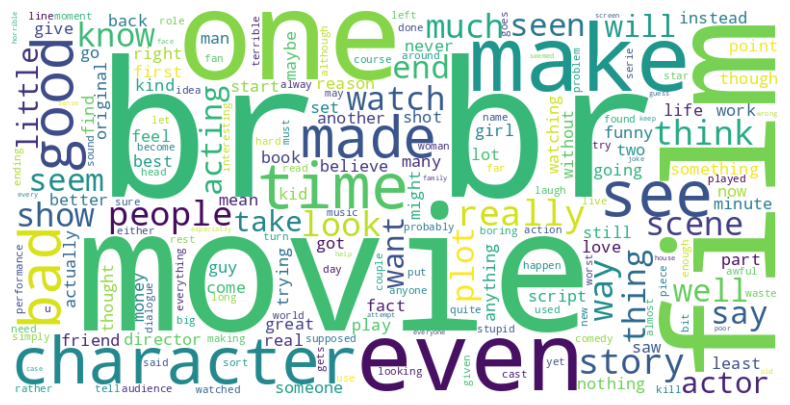

In [9]:
positive_review = df[df['label']== 0]['text']
positive_text = ' '.join(positive_review)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

## Train Test Split

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [11]:
# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Model Development

## Machine Learning Approach

In [12]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Multinomial Naive Bayes": MultinomialNB()
}

In [13]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [14]:
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy * 100:.2f}%")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print('-' * 40)

Logistic Regression Accuracy: 88.97%
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3991
           1       0.88      0.90      0.89      3954

    accuracy                           0.89      7945
   macro avg       0.89      0.89      0.89      7945
weighted avg       0.89      0.89      0.89      7945

Confusion Matrix:
 [[3497  494]
 [ 382 3572]]
----------------------------------------
Multinomial Naive Bayes Accuracy: 86.54%
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      3991
           1       0.87      0.86      0.86      3954

    accuracy                           0.87      7945
   macro avg       0.87      0.87      0.87      7945
weighted avg       0.87      0.87      0.87      7945

Confusion Matrix:
 [[3470  521]
 [ 548 3406]]
----------------------------------------


# Deep Learning approach

## Data Pre-processing

In [15]:
import re
import nltk
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words('english'))


TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)
    
    
def preprocess_text(sen):
    sen = sen.lower()
        
        # Remove html tags
    sentence = remove_tags(sen)

        # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        
        # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

        # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.
        
        # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    return sentence


In [16]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(df['text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [17]:
X[0]

'grew watching loving thunderbirds mates school watched played thunderbirds school lunch school wanted virgil scott one wanted alan counting became art form took children see movie hoping would get glimpse loved child bitterly disappointing high point snappy theme tune could compare original score thunderbirds thankfully early saturday mornings one television channel still plays reruns series gerry anderson wife created jonatha frakes hand directors chair version completely hopeless waste film utter rubbish cgi remake may acceptable replacing marionettes homo sapiens subsp sapiens huge error judgment '

In [18]:
y = df['label']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [20]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [21]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

83861

In [22]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train_padded = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test_padded = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [23]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

#glove_file_path = '/kaggle/input/glove-6b-100d-txt/glove.6B.100d.txt'

embeddings_dictionary = dict()
glove_file = open('/kaggle/input/glove-6b-100d-txt/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [24]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [25]:
embedding_matrix.shape

(83861, 100)

## RNN

In [45]:
# Build the RNN model
rnn = Sequential([
    #Embedding(vocab_length, 100, weights=[embedding_matrix], trainable=False),
    Embedding(input_dim = vocab_length, output_dim = 100, weights = [embedding_matrix], trainable = False),
    SimpleRNN(128),
    Dense(1, activation='sigmoid')
])


In [46]:
# Compile the model
rnn.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
rnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     8,386,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,386,100 (31.99 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,386,100 (31.99 MB)

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [47]:
# Train the model
history = rnn.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test))

Epoch 1/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5566 - loss: 0.6900 - val_accuracy: 0.6686 - val_loss: 0.6165
Epoch 2/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6724 - loss: 0.6126 - val_accuracy: 0.7173 - val_loss: 0.5606
Epoch 3/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7383 - loss: 0.5428 - val_accuracy: 0.7495 - val_loss: 0.5303
Epoch 4/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7657 - loss: 0.5080 - val_accuracy: 0.7770 - val_loss: 0.4932
Epoch 5/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7835 - loss: 0.4823 - val_accuracy: 0.7757 - val_loss: 0.5010


In [48]:
y_pred_prob = rnn.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f" RNN model Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
 RNN model Accuracy: 77.57%
              precision    recall  f1-score   support

           0       0.75      0.82      0.79      3991
           1       0.80      0.73      0.76      3954

    accuracy                           0.78      7945
   macro avg       0.78      0.78      0.78      7945
weighted avg       0.78      0.78      0.78      7945

Confusion Matrix:
 [[3275  716]
 [1066 2888]]


## LSTM

In [31]:
# Build the LSTM model
lstm = Sequential([
    Embedding(input_dim = vocab_length, output_dim = 100, weights = [embedding_matrix], trainable = False),
    LSTM(128, activation = 'tanh'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

In [32]:
# Compile the model
lstm.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     8,386,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,386,100 (31.99 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,386,100 (31.99 MB)

In [33]:
# Train the model
history = lstm.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test))

Epoch 1/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5845 - loss: 0.6527 - val_accuracy: 0.7854 - val_loss: 0.4685
Epoch 2/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7896 - loss: 0.4607 - val_accuracy: 0.7974 - val_loss: 0.4360
Epoch 3/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8018 - loss: 0.4367 - val_accuracy: 0.8070 - val_loss: 0.4189
Epoch 4/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8105 - loss: 0.4168 - val_accuracy: 0.8087 - val_loss: 0.4148
Epoch 5/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8187 - loss: 0.4013 - val_accuracy: 0.8214 - val_loss: 0.3980


In [34]:
y_pred_prob = lstm.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f" LSTM model Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
 LSTM model Accuracy: 82.14%
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      3991
           1       0.85      0.78      0.81      3954

    accuracy                           0.82      7945
   macro avg       0.82      0.82      0.82      7945
weighted avg       0.82      0.82      0.82      7945

Confusion Matrix:
 [[3441  550]
 [ 869 3085]]


## Stacked LSTM

In [35]:
Stacked_lstm = Sequential([
    Embedding(input_dim = vocab_length, output_dim = 100, weights = [embedding_matrix], trainable = False),
    LSTM(128, activation = 'tanh', return_sequences=True),
    Dropout(0.4),
    LSTM(64, activation = 'tanh'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

In [36]:
# Compile the model
Stacked_lstm.compile(optimizer= Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
Stacked_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     8,386,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,386,100 (31.99 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,386,100 (31.99 MB)

In [37]:
# Train the model
history = Stacked_lstm.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test))

Epoch 1/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6121 - loss: 0.6394 - val_accuracy: 0.7746 - val_loss: 0.4781
Epoch 2/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7925 - loss: 0.4519 - val_accuracy: 0.7935 - val_loss: 0.4345
Epoch 3/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8032 - loss: 0.4317 - val_accuracy: 0.8108 - val_loss: 0.4108
Epoch 4/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8169 - loss: 0.4084 - val_accuracy: 0.8113 - val_loss: 0.4129
Epoch 5/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8209 - loss: 0.3964 - val_accuracy: 0.8283 - val_loss: 0.3867


In [38]:
y_pred_prob = Stacked_lstm.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f" Stacked LSTM model Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
 Stacked LSTM model Accuracy: 82.83%
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      3991
           1       0.84      0.82      0.83      3954

    accuracy                           0.83      7945
   macro avg       0.83      0.83      0.83      7945
weighted avg       0.83      0.83      0.83      7945

Confusion Matrix:
 [[3356  635]
 [ 729 3225]]


## GRUs

In [39]:
GRU = Sequential([
    Embedding(input_dim = vocab_length, output_dim = 100, weights = [embedding_matrix], trainable = False),
    GRU(128),
    Dense(1, activation='sigmoid')
])

In [40]:
# Compile the model
GRU.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
GRU.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     8,386,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,386,100 (31.99 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,386,100 (31.99 MB)

In [41]:
# Train the model
history = GRU.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test))

Epoch 1/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5412 - loss: 0.6824 - val_accuracy: 0.7665 - val_loss: 0.5289
Epoch 2/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7765 - loss: 0.4812 - val_accuracy: 0.7963 - val_loss: 0.4511
Epoch 3/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8068 - loss: 0.4272 - val_accuracy: 0.7997 - val_loss: 0.4274
Epoch 4/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8183 - loss: 0.4044 - val_accuracy: 0.8140 - val_loss: 0.4071
Epoch 5/5
497/497 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8277 - loss: 0.3842 - val_accuracy: 0.8291 - val_loss: 0.3852


In [42]:
y_pred_prob = GRU.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f" GRU model Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
 GRU model Accuracy: 82.91%
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      3991
           1       0.82      0.85      0.83      3954

    accuracy                           0.83      7945
   macro avg       0.83      0.83      0.83      7945
weighted avg       0.83      0.83      0.83      7945

Confusion Matrix:
 [[3242  749]
 [ 609 3345]]


## Stacked GRU

In [53]:
accuracies = {
    "Logistic Regression": 88.97,
    "Multinomial NB": 86.54,
    "RNN": 77.57,
    "LSTM": 82.14,
    "Stacked LSTM": 82.83,
    "GRU": 82.91
}

accuracies_df = pd.DataFrame(accuracies.items(), columns=['Model', 'Accuracy'])
accuracies_df

,Model,Accuracy
0,Logistic Regression,88.97
1,Multinomial NB,86.54
2,RNN,77.57
3,LSTM,82.14
4,Stacked LSTM,82.83
5,GRU,82.91


**Based on the obtained accuracies, Logistic Regression achieved the highest accuracy of 88.97%, closely followed by GRU at 82.91%. This suggests Logistic Regression as the preferred choice for this sentiment analysis task due to superior accuracy. However, considerations such as computational resources and interpretability favor Logistic Regression's simplicity over GRU and LSTM models. Further experimentation with GRU or LSTM could potentially enhance performance with additional tuning, reflecting the nuanced decision-making process in model selection for sentiment analysis.**